In [1]:
import warnings
warnings.filterwarnings("ignore")

import glob

from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1113 21:37:56.191357 139726063118144 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1113 21:37:56.262348 139726063118144 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [14]:
data_dir = Path("/media/wwymak/Storage/xView2")
classifcation_crop_dir = data_dir/"classification_crops"
classification_labels = pd.read_csv(data_dir/"train.csv")

In [3]:
classifcation_crop_dir.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/classification_crops/6671477c-797b-4074-a598-c9e06cb3af0b.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops/f3ba72f9-9761-4e5a-9e94-b9863923bcc4.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops/6e3b9d26-c964-45ee-b2b2-26c882d86bd5.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops/8da51dbf-8b60-450c-a767-5a647daced8a.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops/6217f278-cf83-4384-b81e-eaca0dda8d67.png')]

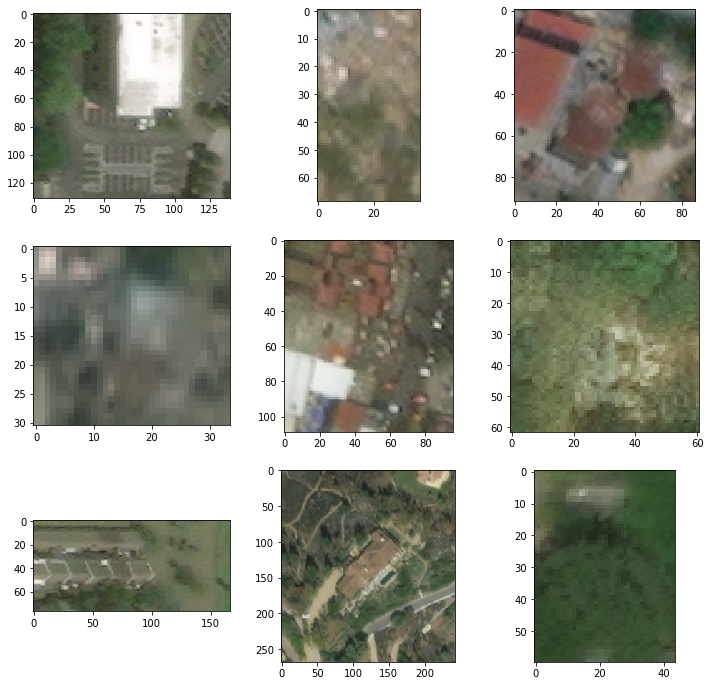

In [4]:
samples = [np.array(PIL.Image.open(f)) for f in classifcation_crop_dir.ls()[:9]]
f, ax = plt.subplots(3,3,figsize=(12,12))
axs = ax.ravel()
_=[axs[i].imshow(s) for i, s in zip(range(len(axs)), samples)]


In [15]:
classification_labels.head()

,uuid,img_id,label,crop_filename
0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8,palu-tsunami_00000024_post_disaster.png,0,c18d34cd-d48d-43ba-9d9c-011b6f9d5eb8.png
1,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1,palu-tsunami_00000024_post_disaster.png,0,4db83f7b-7c77-4cb4-8ea7-ad5a338a92b1.png
2,fc34426b-db11-403d-bdcf-1527b7d2508a,palu-tsunami_00000024_post_disaster.png,0,fc34426b-db11-403d-bdcf-1527b7d2508a.png
3,052f9f14-e32e-484a-811d-cd0fac134493,palu-tsunami_00000024_post_disaster.png,0,052f9f14-e32e-484a-811d-cd0fac134493.png
4,577576f3-3bdc-41ec-a571-6f6cf843cf3b,palu-tsunami_00000024_post_disaster.png,0,577576f3-3bdc-41ec-a571-6f6cf843cf3b.png


In [22]:
classification_labels_mini = classification_labels.sample(n=10000)

In [49]:


def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    
train_ids, valid_ids = get_train_valid_ids(classification_labels_mini)

In [50]:
valid_ids[:5]

array(['5f39350b-9f53-4154-bc05-45bc7abb5fe5.png', '023de14d-25a2-42ac-95ba-b4a36235ad88.png',
       'd0765216-993a-4069-9364-de6c7dd94fea.png', '4ef9029e-fe36-4fb1-a551-d8a1188020e6.png',
       '04666c0c-1140-49d2-8a2e-5be9c79fdb07.png'], dtype=object)

In [55]:

def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids

In [56]:
size=64
bs=32
src = (ImageList
       .from_df(classification_labels_mini, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

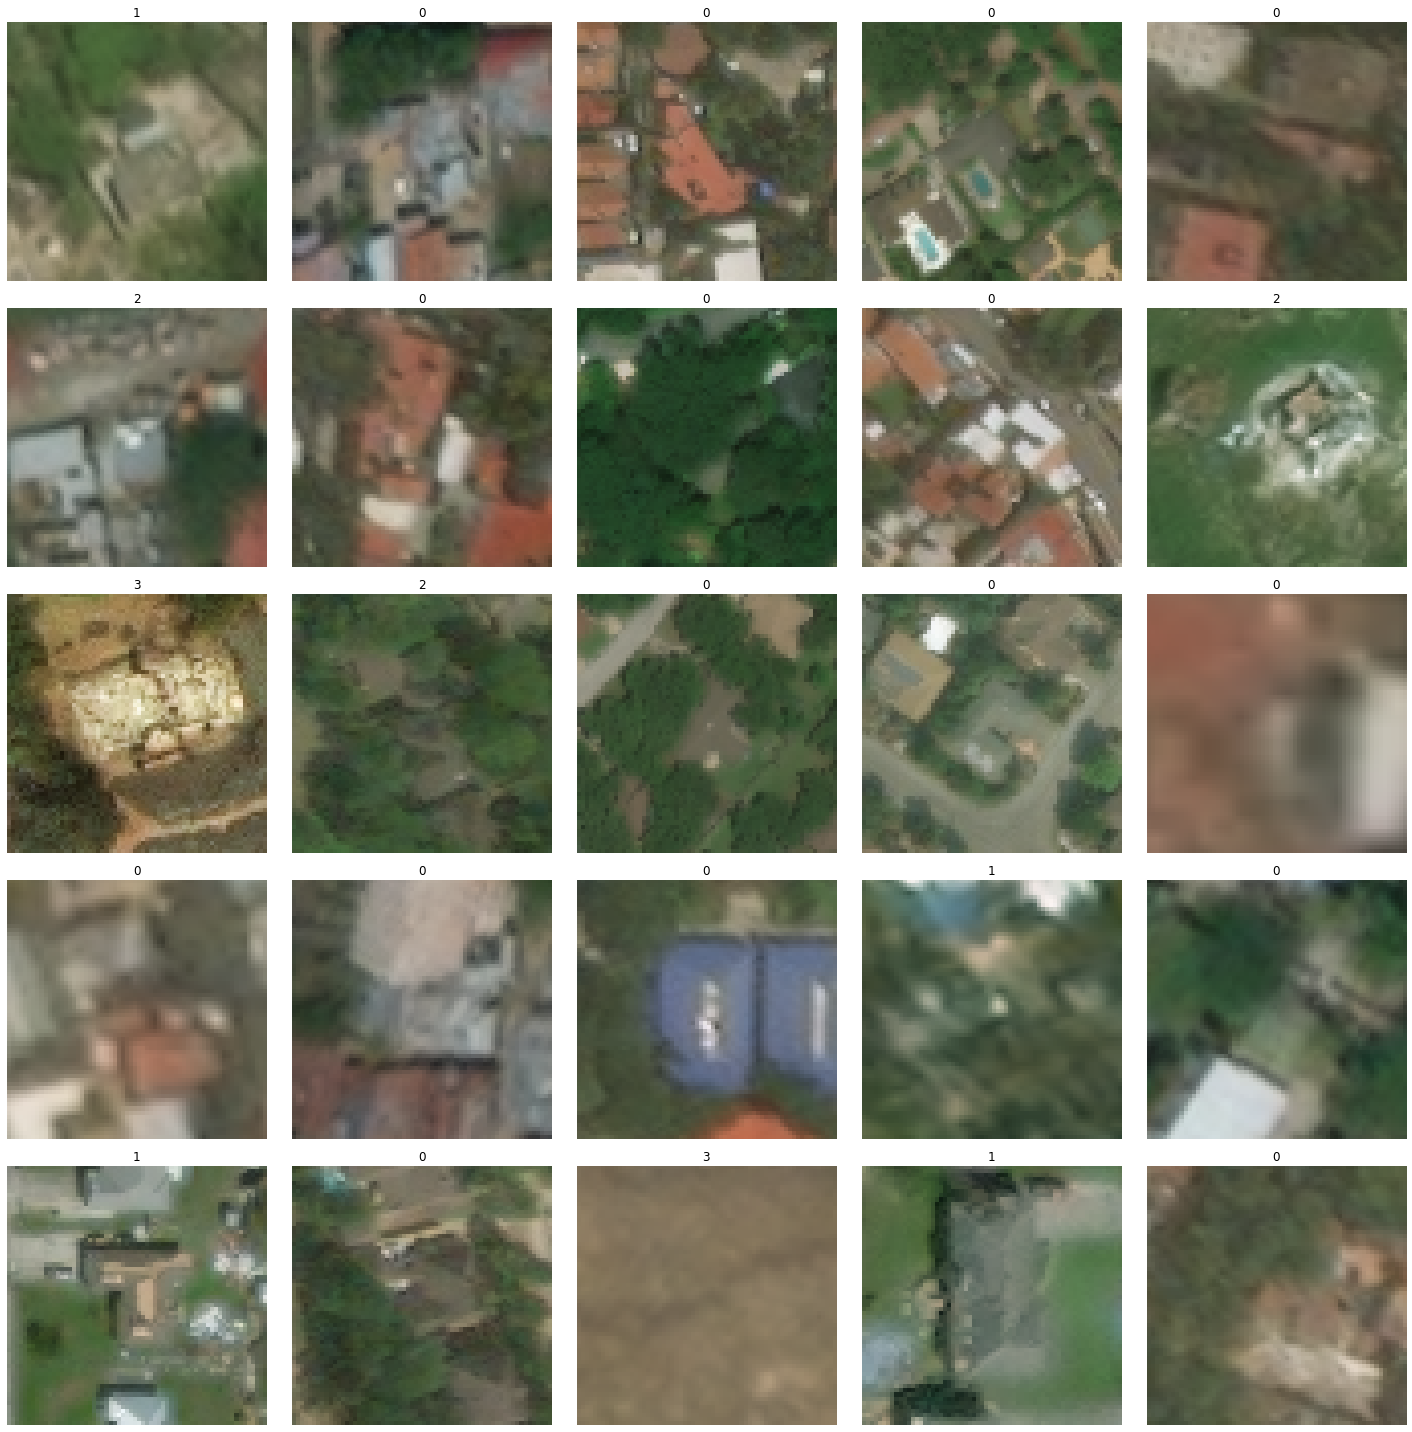

In [57]:
data.show_batch(ds_type=DatasetType.Valid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


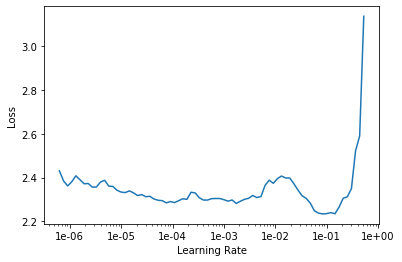

In [69]:
f1 = partial(MultiLabelFbeta, beta=1, average="macro")

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, partial(fbeta, beta=1)] )
learn.lr_find()
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,fbeta,time


RuntimeError: The size of tensor a (4) must match the size of tensor b (32) at non-singleton dimension 1

In [68]:
fbeta??